# Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

transform = transforms.ToTensor()

#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
#])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_data,
                                           batch_size=64,
                                           shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14942289.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 507349.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4411286.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9995030.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
dataiter = iter(mnist_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
      # N, 784
      super().__init__()
      self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # Nx724 -> Nx128
        nn.ReLU(),
        nn.Linear(128, 64), # Nx128 -> Nx64
        nn.ReLU(),
        nn.Linear(64, 12), # Nx64 -> Nx12
        nn.ReLU(),
        nn.Linear(12, 3) # Nx12 -> Nx3
      )

      self.decoder = nn.Sequential(
          nn.Linear(3, 12),
          nn.ReLU(),
          nn.Linear(12, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 28*28),
          nn.Sigmoid() # Nx3 -> Nx784
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [16]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

In [17]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for (img, _) in mnist_loader:
    img = img.reshape(-1, 28*28)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0535
Epoch:2, Loss:0.0439
Epoch:3, Loss:0.0391
Epoch:4, Loss:0.0408
Epoch:5, Loss:0.0372
Epoch:6, Loss:0.0364
Epoch:7, Loss:0.0382
Epoch:8, Loss:0.0377
Epoch:9, Loss:0.0335
Epoch:10, Loss:0.0297


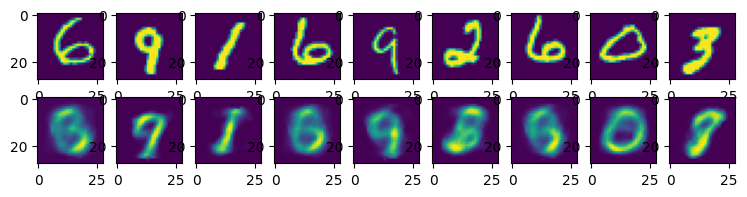

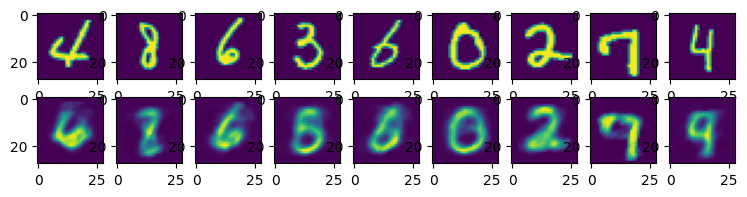

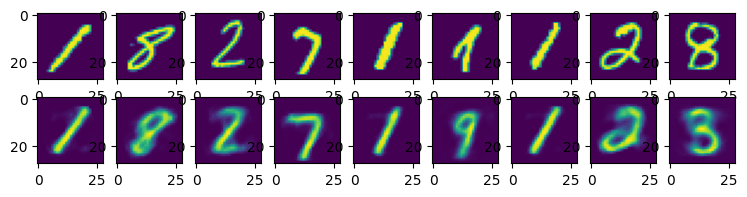

In [19]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9, 2))
  plt.gray
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:
      break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9:
      break
    plt.subplot(2, 9, 9+i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

# Convolutional Autoencoder

In [2]:
class AutoEncoderCNN(nn.Module):
    def __init__(self):
      # N, 1, 28, 28
      super().__init__()
      self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # Nx16x14x14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # Nx32x7x7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # Nx64x1x1
      )

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(64, 32, 7), # Nx32x7x7
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # Nx16x14x14
          nn.ReLU(),
          nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # Nx1x28x28
          nn.Sigmoid()
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [4]:
model = AutoEncoderCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

In [5]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for (img, _) in mnist_loader:
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0104
Epoch:2, Loss:0.0050
Epoch:3, Loss:0.0045
Epoch:4, Loss:0.0040
Epoch:5, Loss:0.0030
Epoch:6, Loss:0.0029
Epoch:7, Loss:0.0030
Epoch:8, Loss:0.0031
Epoch:9, Loss:0.0031
Epoch:10, Loss:0.0023


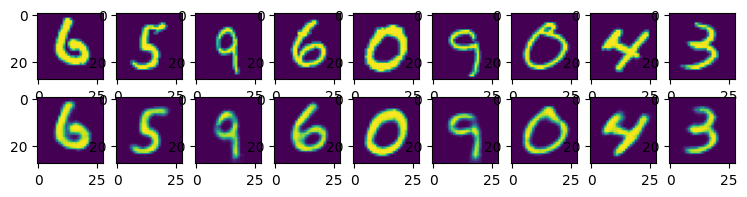

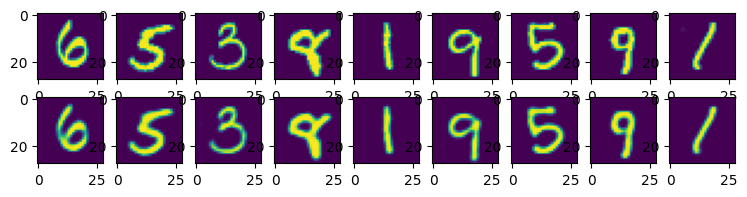

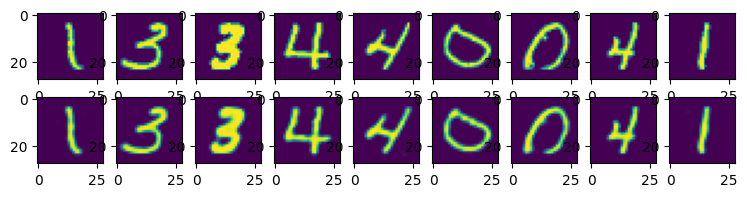

In [7]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9, 2))
  plt.gray
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:
      break
    plt.subplot(2, 9, i+1)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9:
      break
    plt.subplot(2, 9, 9+i+1)
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])